# Bayesian Hierarchical Lee-Carter

This code implements the Bayesian Hierarhcical Lee-Carter Model for mulitple populations outlined in Shi et al. (2023).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cmdstanpy as stan
stan.install_cmdstan()
import arviz
import csv

CmdStan install directory: /Users/paigepark/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


Load data

In [5]:
state_training = np.loadtxt('../../data/state_training.txt')
state_test = np.loadtxt('../../data/state_test.txt')
state_final_test = np.loadtxt('../../data/state_final_test.txt')

In [6]:
state_training[:,4] = np.log(state_training[:,4] + 1e-6)
state_test[:,4] = np.log(state_test[:,4] + 1e-6)
state_final_test[:,4] = np.log(state_final_test[:,4] + 1e-6)

In [7]:
state_training_f = state_training[state_training[:,1] == 0]
state_training_m = state_training[state_training[:,1] == 1]
state_training_f = np.delete(state_training_f, 1, 1)
state_training_m = np.delete(state_training_m, 1, 1)

In [15]:
print(state_training_f)

[[ 0.00000000e+00  1.95900000e+03  0.00000000e+00 -3.50485934e+00]
 [ 0.00000000e+00  1.95900000e+03  1.00000000e+00 -6.34756823e+00]
 [ 0.00000000e+00  1.95900000e+03  2.00000000e+00 -7.01200530e+00]
 ...
 [ 4.90000000e+01  2.00500000e+03  9.70000000e+01 -1.24361147e+00]
 [ 4.90000000e+01  2.00500000e+03  9.80000000e+01 -1.15835911e+00]
 [ 4.90000000e+01  2.00500000e+03  9.90000000e+01 -1.07628051e+00]]


In [8]:
state_training_two_states = state_training_f[(state_training_f[:, 0] == 1) | (state_training_f[:, 0] == 2)]

In [11]:
state_training_two_states

array([[ 1.        ,  1.        ,  0.        , -3.51893417],
       [ 1.        ,  1.        ,  1.        , -6.03604359],
       [ 1.        ,  1.        ,  2.        , -6.69183777],
       ...,
       [ 2.        , 47.        , 97.        , -1.12060946],
       [ 2.        , 47.        , 98.        , -1.03136213],
       [ 2.        , 47.        , 99.        , -0.94633508]])

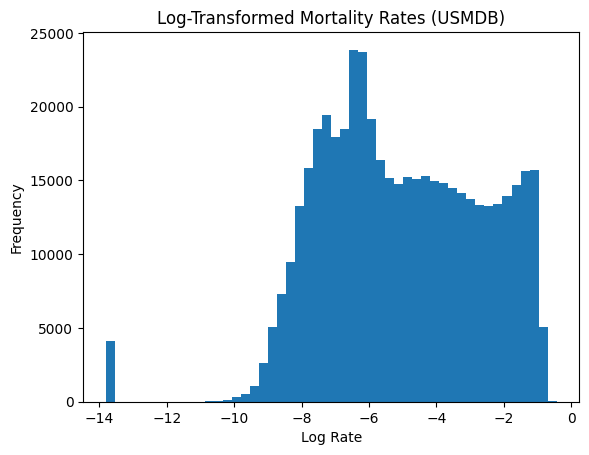

In [8]:
plt.hist(state_training[:, 4], bins=50)
plt.title("Log-Transformed Mortality Rates (USMDB)")
plt.xlabel("Log Rate")
plt.ylabel("Frequency")
plt.show()


In [6]:
country_training = np.loadtxt('../../data/country_training.txt')
country_test = np.loadtxt('../../data/country_test.txt')
country_final_test = np.loadtxt('../../data/country_final_test.txt')

In [7]:
country_training[:,4] = np.log(country_training[:,4] + 1e-6)
country_test[:,4] = np.log(country_test[:,4] + 1e-6)
country_final_test[:,4] = np.log(country_final_test[:,4] + 1e-6)

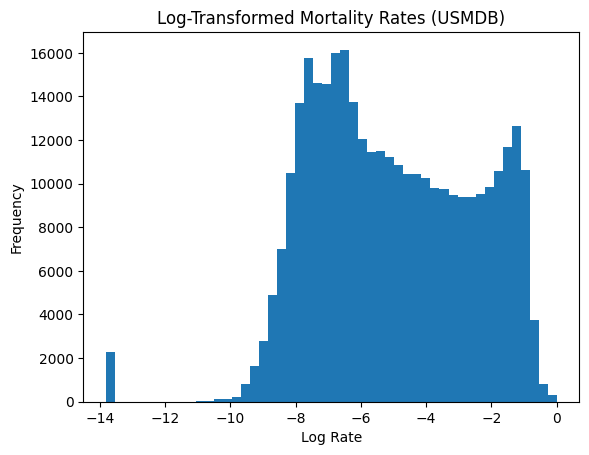

In [8]:
plt.hist(country_training[:, 4], bins=50)
plt.title("Log-Transformed Mortality Rates (USMDB)")
plt.xlabel("Log Rate")
plt.ylabel("Frequency")
plt.show()


In [9]:
combined_training = np.loadtxt('../../data/combined_training.txt')
combined_test = np.loadtxt('../../data/combined_test.txt')
combined_final_test = np.loadtxt('../../data/combined_final_test.txt')

In [10]:
combined_training[:,4] = np.log(combined_training[:,4] + 1e-6)
combined_test[:,4] = np.log(combined_test[:,4] + 1e-6)
combined_final_test[:,4] = np.log(combined_final_test[:,4] + 1e-6)

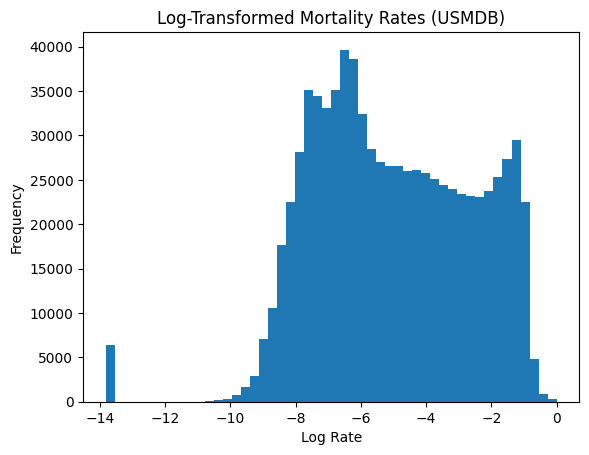

In [11]:
plt.hist(combined_training[:, 4], bins=50)
plt.title("Log-Transformed Mortality Rates (USMDB)")
plt.xlabel("Log Rate")
plt.ylabel("Frequency")
plt.show()

Prep data (starting with the states model)

In [9]:
num_populations = len(np.unique(state_training_two_states[:,0]))
num_ages = len(np.unique(state_training_two_states[:,2]))
num_years = len(np.unique(state_training_two_states[:,1]))
#num_genders = len(np.unique(state_training[:,1]))

min_year = np.min(state_training_two_states[:, 1])  
state_training_two_states[:, 1] -= (min_year - 1)  # Offset so the minimum year becomes 1

# data dictionary 
data = {'N': len(state_training_two_states),
        'I': num_populations,
        'X': num_ages,
        'T': num_years,
        'population': state_training_two_states[:, 0].astype(int), # + 1, # figure out whether this is correct
        'age': state_training_two_states[:, 2].astype(int) + 1,
        'year': state_training_two_states[:, 1].astype(int),
        'log_mortality': state_training_two_states[:, 3]   
        }

In [10]:
print(state_training_two_states)

[[ 1.          1.          0.         -3.51893417]
 [ 1.          1.          1.         -6.03604359]
 [ 1.          1.          2.         -6.69183777]
 ...
 [ 2.         47.         97.         -1.12060946]
 [ 2.         47.         98.         -1.03136213]
 [ 2.         47.         99.         -0.94633508]]


Set up code to run model

In [14]:
sm = stan.CmdStanModel(stan_file='bhlc_model.stan') # instantiating, compiling the model
fit = sm.sample(data=data, iter_sampling=1000, 
                iter_warmup=1000, chains=4, 
                adapt_delta=0.95,
                show_console=True,
                max_treedepth=12, parallel_chains=4)
print(fit.summary())
print(fit.diagnose())

10:50:53 - cmdstanpy - INFO - compiling stan file /Users/paigepark/Desktop/deep-mort/code/BHM/bhlc_model.stan to exe file /Users/paigepark/Desktop/deep-mort/code/BHM/bhlc_model
10:51:06 - cmdstanpy - INFO - compiled model executable: /Users/paigepark/Desktop/deep-mort/code/BHM/bhlc_model
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [2] start processing
10:51:06 - cmdstanpy - INFO - Chain [3] start processing
10:51:06 - cmdstanpy - INFO - Chain [4] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.95
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 12
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/1z/wn6shwbs4_9gcwtsrgz8v5vc0000gn/T/tmpz4mfbgvo/1h0l55ud.json
Chain [1] init = 2 (Default)
Chain [1] random
Chai

11:12:52 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] 
Chain [4] Elapsed Time: 929.18 seconds (Warm-up)
Chain [4] 375.939 seconds (Sampling)
Chain [4] 1305.12 seconds (Total)
Chain [4] 
Chain [4] 
Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [2] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)


11:13:49 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 962.519 seconds (Warm-up)
Chain [2] 399.792 seconds (Sampling)
Chain [2] 1362.31 seconds (Total)
Chain [2] 
Chain [2] 
Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)


11:13:53 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] 
Chain [3] Elapsed Time: 986.097 seconds (Warm-up)
Chain [3] 380.906 seconds (Sampling)
Chain [3] 1367 seconds (Total)
Chain [3] 
Chain [3] 
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)


11:14:08 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 1007.38 seconds (Warm-up)
Chain [1] 374.171 seconds (Sampling)
Chain [1] 1381.55 seconds (Total)
Chain [1] 
Chain [1] 
                       Mean       MCSE     StdDev        MAD           5%  \
lp__            9875.580000  14.584200  29.903400  29.948500  9822.230000   
mu_alpha          -2.724890   0.091153   0.233501   0.238461    -3.118880   
sigma_alpha        1.400480   0.001797   0.069490   0.069719     1.290790   
alpha_raw[1,1]     2.750420   0.012615   0.372239   0.376039     2.167370   
alpha_raw[1,2]     2.999050   0.011132   0.374834   0.374490     2.399460   
...                     ...        ...        ...        ...          ...   
beta[98,2]         0.022263   0.021631   0.257736   0.241392    -0.396994   
beta[99,1]        -0.126118   0.173273   0.361438   0.328496    -0.656461   
beta[99,2]         0.025727   0.005081   0.248936   0.232971    -0.380003   
beta[100,1]       -0.153782   0.220181   0.406671   0.362715    -0.737459   

In [ ]:
fit.save_csvfiles("bayes_model.csv")